In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import tqdm
import scipy 

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
base_path5 = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-2/202112/' #xmas ws bkg
runs5 = range(6771,6790) #xmas WSbkg

files = []

for run in runs5:
    files.extend(glob.glob(base_path5 + '*{0:06d}/rq/*.root'.format(run)))

print(len(files))

1140


In [3]:
def pulsestats(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')
    nSS = scatters.array('ss.nSingleScatters')
    DS1 = scatters.array('ss.isDoubleS1')
    x = events.array('pulsesTPC.s2Xposition_cm')
    y = events.array('pulsesTPC.s2Yposition_cm')
    nPU = scatters.array('pileUp.nPileUpScatters')
    drift = scatters.array('ss.driftTime_ns')/ 1000
    maxS2 = events.array('pulsesTPC.maxS2PulseID')

    #get the r of the largest S2 since its the closest we can get to a single prominent 
    Allx = []
    Ally = []
    for i,j in zip(x,maxS2):
        Allx.append(i[j])
    for i,j in zip(y,maxS2):
        Ally.append(i[j])

    isSS = nSS > 0
    SSx = [np.array(Allx)[isSS]]
    SSy = [np.array(Ally)[isSS]]
    try:
        while True:
            SSx.remove(999.0)
            SSy.remove(999.0)
    except ValueError:
        pass
    SSr = np.sqrt(np.power(SSx,2) + np.power(SSy,2))   

    isPU = nPU > 0
    PUx = [np.array(Allx)[isPU]]
    PUy = [np.array(Ally)[isPU]]
    try:
        while True:
            PUx.remove(999.0)
            PUy.remove(999.0)
    except ValueError:
        pass
    PUr = np.sqrt(np.power(PUx,2) + np.power(PUy,2))

    try:
        while True:
            Allx.remove(999.0)
            Ally.remove(999.0)
    except ValueError:
        pass

    Allr = np.sqrt(np.power(Allx,2) + np.power(Ally,2))
    return nSS,Allx,Ally,Allr,nPU,SSx,SSy,SSr,PUx,PUy,PUr

In [4]:
thefile = '/global/cfs/cdirs/lz/data/reconstructed/SR1/LZAP-5.4.6_PROD-2/202112/lz_202112231601_006773/rq/lz_006773_000019_rq.root'
events = uproot.open(thefile)['Events']
scatters = uproot.open(thefile)['Scatters']
runID = events.array('eventHeader.runID')
eventID = events.array('eventHeader.eventID')
nSS = scatters.array('ss.nSingleScatters')
DS1 = scatters.array('ss.isDoubleS1')
x = events.array('pulsesTPC.s2Xposition_cm')
y = events.array('pulsesTPC.s2Yposition_cm')
nPU = scatters.array('pileUp.nPileUpScatters')
drift = scatters.array('ss.driftTime_ns')/ 1000
maxS2 = events.array('pulsesTPC.maxS2PulseID')

#get the r of the largest S2 since its the closest we can get to a single prominent 
Allx = []
Ally = []
for i,j in zip(x,maxS2):
    Allx.append(i[j])
for i,j in zip(y,maxS2):
    Ally.append(i[j])

isSS = nSS > 0
SSx = [np.array(Allx)[isSS]]
SSy = [np.array(Ally)[isSS]]
try:
    while True:
        SSx.remove(999.0)
        SSy.remove(999.0)
except ValueError:
    pass
SSr = np.sqrt(np.power(SSx,2) + np.power(SSy,2))   

isPU = nPU > 0
PUx = [np.array(Allx)[isPU]]
PUy = [np.array(Ally)[isPU]]
try:
    while True:
        PUx.remove(999.0)
        PUy.remove(999.0)
except ValueError:
    pass
PUr = np.sqrt(np.power(PUx,2) + np.power(PUy,2))

try:
    while True:
        Allx.remove(999.0)
        Ally.remove(999.0)
except ValueError:
    pass

Allr = np.sqrt(np.power(Allx,2) + np.power(Ally,2))


/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in power
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power


In [5]:
nSS = []
x = []
y = []
r = []
nPU = []
SSx = []
SSy = []
SSr = []
PUx = []
PUy = []
PUr = []

In [6]:
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files))) 

0it [00:00, ?it/s]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in power
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power
1it [00:02,  2.98s/it]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power
11it [00:03,  1.09s/it]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power
12it [00:03,  1.23it/s]/global/homes/m/mrw7816/mi

In [7]:
for i in results:
    nSS.append(i[0])
    x.append(i[1])
    y.append(i[2])
    r.append(i[3])
    nPU.append(i[4])
    SSx.append(i[5])
    SSy.append(i[6])
    SSr.append(i[7])
    PUx.append(i[8])
    PUy.append(i[9])
    PUr.append(i[10])

In [8]:
nSS = list(itertools.chain.from_iterable(nSS))
x = list(itertools.chain.from_iterable(x))
y = list(itertools.chain.from_iterable(y))
r = list(itertools.chain.from_iterable(r))
nPU = list(itertools.chain.from_iterable(nPU))
SSx = list(itertools.chain.from_iterable(SSx))
SSy = list(itertools.chain.from_iterable(SSy))
SSr = list(itertools.chain.from_iterable(SSr))
PUx = list(itertools.chain.from_iterable(PUx))
PUy = list(itertools.chain.from_iterable(PUy))
PUr = list(itertools.chain.from_iterable(PUr))

ValueError: autodetected range of [-inf, 483.8111877441406] is not finite

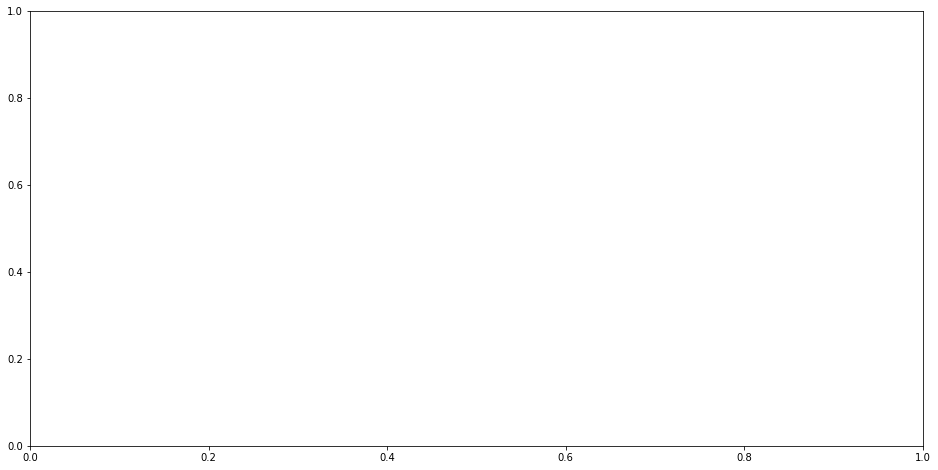

In [9]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(x, y, bins=(100,100),norm=matplotlib.colors.LogNorm())
plt.colorbar()